In [1]:
#!pip install folium
#!pip install lightgbm
#!pip install impyute

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import folium
from folium.plugins import FloatImage
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import warnings
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

In [3]:
listings = pd.read_csv('airbnb/listings.csv.gz')
calendar = pd.read_csv('airbnb/calendar.csv.gz')
reviews = pd.read_csv('airbnb/reviews.csv.gz')

In [4]:
print("Shapes of all the sources:")
print("{}: {}".format("calendar", calendar.shape))
print("{}: {}".format("reviews", calendar.shape))
print("{}: {}".format("listings", calendar.shape))

Shapes of all the sources:
calendar: (8539992, 7)
reviews: (8539992, 7)
listings: (8539992, 7)


In [5]:
listings.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,20191207213017,2019-12-08,Beautiful home in amazing area!,"This large, family home is located in one of T...",Visit Toronto with this fabulous furnished hom...,"This large, family home is located in one of T...",none,The apartment is located in the Ossington stri...,"To learn a little more about our home, see: (U...",All forms of public transportation are easily ...,The whole house and garden are available.,"We will be out of town, but fully accessible b...",This is our much-loved family home. We expect ...,NaN,NaN,https://a0.muscache.com/im/pictures/76206750/d...,NaN,1565,https://www.airbnb.com/users/show/1565,Alexandra,2008-08-08,"Toronto, Ontario, Canada","I live in Toronto, Canada with my husband and ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1565/profile_...,https://a0.muscache.com/im/users/1565/profile_...,Commercial Drive,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Toronto, ON, Canada",Little Portugal,Little Portugal,NaN,Toronto,ON,M6J,Toronto,"Toronto, Canada",CA,Canada,43.64617,-79.42451,...,7.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",1400.0,$469.00,"$2,000.00",NaN,"$1,000.00",$150.00,1,$0.00,4,730,4,4,730,730,4.0,730.0,22 months ago,t,0,0,0,0,2019-12-08,7,0,2015-07-19,2017-12-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.13


In [6]:
calendar.head(1)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,291699,2019-12-08,t,$34.00,$34.00,80.0,90.0


In [7]:
### Calendar preprocessing

calendar.available = calendar.available.map(lambda x: 1 if x=='t' else 0)
calendar.date = pd.to_datetime(calendar.date)
calendar.price = calendar.price.str.replace("$", "").str.replace(",","")
calendar.price = calendar.price.astype("float")
calendar.adjusted_price = calendar.adjusted_price.str.replace("$", "").str.replace(",","")
calendar.adjusted_price = calendar.adjusted_price.astype("float")

In [8]:
print('Minimum date of listing: {}'.format(calendar.date.min()))
print('Maximum date of listing: {}'.format(calendar.date.max()))

Minimum date of listing: 2019-12-07 00:00:00
Maximum date of listing: 2020-12-06 00:00:00


In [9]:
####  Creating grouped calendar for visualizations

calendar_365 = calendar.groupby('date')['available', 'price'].mean().reset_index()
calendar_365.rename(columns={'price': 'average_price', 'available': 'vacancy'}, inplace=True)

In [10]:
calendar_365['occupancy'] = (1 - calendar_365['vacancy']) * 100
calendar_365['dayofweek'] = calendar_365.date.dt.weekday_name.str[:3]
calendar_365['month'] = calendar_365.date.dt.month_name().str[:3]

In [11]:
calendar_365.head()

,date,vacancy,average_price,occupancy,dayofweek,month
0,2019-12-07,0.014997,154.398500,98.500268,Sat,Dec
1,2019-12-08,0.260632,130.706928,73.936830,Sun,Dec
2,2019-12-09,0.338248,130.979527,66.175151,Mon,Dec
3,2019-12-10,0.358849,131.283455,64.115057,Tue,Dec
4,2019-12-11,0.377570,131.149164,62.243023,Wed,Dec


In [12]:
def plot_calendar(groupby_col, agg_col):
    
    df_index = list(calendar_365[groupby_col].unique())
    grouped_df = calendar_365.groupby(groupby_col)[agg_col].mean().reindex(df_index)

    plt.plot(grouped_df)
    plt.ylabel(agg_col.replace('_', ' ').title())
    plt.title(" {} by {}".format(agg_col.replace('_', ' ').title(),groupby_col.title()), fontsize=18, fontweight='bold')
    
    ticks = list(range(len(df_index)))
    labels = df_index
    plt.xticks(ticks, labels)
    
    plt.show()

## Which months are busiest and idlest to visit Toronto?

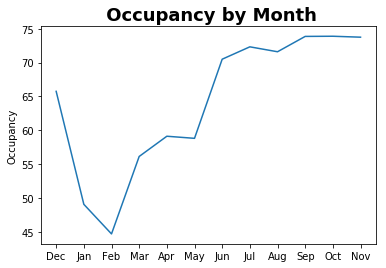

In [13]:
plot_calendar('month', 'occupancy')

## Which days of week are most busy and least busy to visit Toronto?

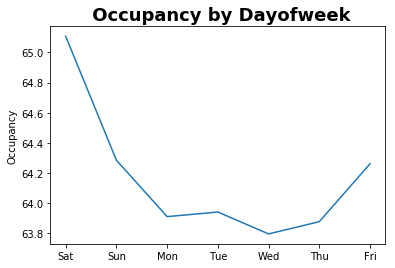

In [14]:
plot_calendar('dayofweek', 'occupancy')

## Which days of week are most expensive and least expensive to visit Toronto?

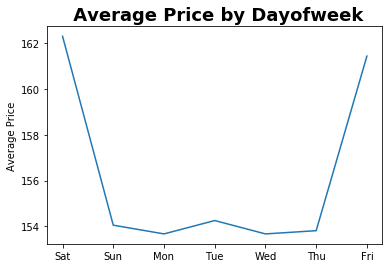

In [15]:
plot_calendar('dayofweek', 'average_price')

## Which neighborhoods has the most and the least expensive listings?

In [16]:
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,20191207213017,2019-12-08,Beautiful home in amazing area!,"This large, family home is located in one of T...",Visit Toronto with this fabulous furnished hom...,"This large, family home is located in one of T...",none,The apartment is located in the Ossington stri...,"To learn a little more about our home, see: (U...",All forms of public transportation are easily ...,The whole house and garden are available.,"We will be out of town, but fully accessible b...",This is our much-loved family home. We expect ...,NaN,NaN,https://a0.muscache.com/im/pictures/76206750/d...,NaN,1565,https://www.airbnb.com/users/show/1565,Alexandra,2008-08-08,"Toronto, Ontario, Canada","I live in Toronto, Canada with my husband and ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1565/profile_...,https://a0.muscache.com/im/users/1565/profile_...,Commercial Drive,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Toronto, ON, Canada",Little Portugal,Little Portugal,NaN,Toronto,ON,M6J,Toronto,"Toronto, Canada",CA,Canada,43.64617,-79.42451,...,7.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",1400.0,$469.00,"$2,000.00",NaN,"$1,000.00",$150.00,1,$0.00,4,730,4,4,730,730,4.0,730.0,22 months ago,t,0,0,0,0,2019-12-08,7,0,2015-07-19,2017-12-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.13
1,8077,https://www.airbnb.com/rooms/8077,20191207213017,2019-12-08,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,My husband and I are both artists. I give pain...,Guest room in a luxury condo with access to al...,none,NaN,NaN,NaN,NaN,NaN,No smoking please.,NaN,NaN,https://a0.muscache.com/im/pictures/11780344/1...,NaN,22795,https://www.airbnb.com/users/show/22795,Kathie & Larry,2009-06-22,"Toronto, Ontario, Canada",My husband and I have been airbnb host for alm...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/9a077...,https://a0.muscache.com/im/pictures/user/9a077...,Harbourfront,2.0,2.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Toronto, ON, Canada",Downtown Toronto,Waterfront Communities-The Island,NaN,Toronto,ON,M5J,Toronto,"Toronto, Canada",CA,Canada,43.64105,-79.37628,...,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,$99.00,NaN,"$2,651.00"

In [17]:
### Count of listings

listings.groupby('neighbourhood_cleansed')['id'].count().head()

neighbourhood_cleansed
Agincourt North                  51
Agincourt South-Malvern West    103
Alderwood                        33
Annex                           851
Banbury-Don Mills                66
Name: id, dtype: int64

In [18]:
def count_plot(df, groupby_col, agg_col, plot_type, top_k=10):
    
    if plot_type == 'count':

        if agg_col == 'id':
            grouped_df = df.groupby(groupby_col)[agg_col].count()
            order_index = grouped_df.sort_values(ascending=False).index[:top_k]
            
            splot = sns.countplot(x=groupby_col, data=df,palette="Set1",
                                  order=order_index)

            

            plt.xlabel('Neighborhood')
            plt.ylabel('Listings count')
            plt.title('Top neighborhoods based on listing counts',
                      fontsize=18, fontweight='bold')
            
            
        
    plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'
    )
    plt.show()

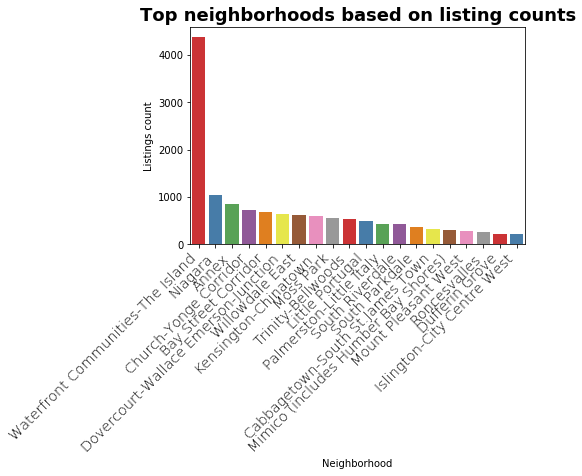

In [19]:
count_plot(listings, 'neighbourhood_cleansed', 'id', 'count', 20)

In [20]:
listings.price = listings.price.str.replace("$", "").str.replace(",","")
listings.price = listings.price.astype("float")

In [21]:
### Average price per neighbourhood

listings.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)[:20]

neighbourhood_cleansed
Forest Hill South                    358.833333
Casa Loma                            333.717391
Waterfront Communities-The Island    226.676571
Kensington-Chinatown                 218.090604
Clanton Park                         197.137500
Rosedale-Moore Park                  196.649573
Kingsway South                       196.000000
Lawrence Park South                  185.033333
Lawrence Park North                  179.385965
Bedford Park-Nortown                 178.836735
Bay Street Corridor                  173.870262
Annex                                173.320799
Edenbridge-Humber Valley             170.304348
Niagara                              166.900763
Leaside-Bennington                   166.508475
Church-Yonge Corridor                164.674515
Yonge-Eglinton                       163.633333
Banbury-Don Mills                    162.212121
Markland Wood                        159.500000
Yonge-St.Clair                       157.678161
Name: price, dtyp

In [22]:
listings.price.describe()

count    23397.000000
mean       148.707099
std        329.417941
min          0.000000
25%         65.000000
50%         99.000000
75%        160.000000
max      13255.000000
Name: price, dtype: float64

In [23]:
### Minimum listing and the neighbourhood

listings[listings.price == listings.price.min()][['neighbourhood_cleansed', 'price']]

,neighbourhood_cleansed,price
7971,Little Portugal,0.0
8031,Agincourt North,0.0
8148,Dovercourt-Wallace Emerson-Junction,0.0
8273,Hillcrest Village,0.0


In [24]:
### Maximum listing and the neighbourhood

listings[listings.price == listings.price.max()][['neighbourhood_cleansed', 'price']]

,neighbourhood_cleansed,price
5778,Annex,13255.0


## Price vs Number of Reviews

Text(0.5, 1.0, 'Price vs Number of Reviews')

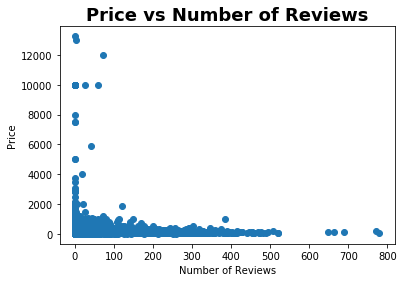

In [25]:
plt.scatter(x=listings['number_of_reviews'], y=listings['price'])
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.title('Price vs Number of Reviews', fontsize=18, fontweight='bold')

In [26]:
grouped_df = listings.groupby('neighbourhood_cleansed')['id'].count()
top_nbrhd_list = list(grouped_df.sort_values(ascending=False).index[:25])
top_nbrhd = listings[listings['neighbourhood_cleansed'].isin(top_nbrhd_list)]

In [27]:
top_nbrhd.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,20191207213017,2019-12-08,Beautiful home in amazing area!,"This large, family home is located in one of T...",Visit Toronto with this fabulous furnished hom...,"This large, family home is located in one of T...",none,The apartment is located in the Ossington stri...,"To learn a little more about our home, see: (U...",All forms of public transportation are easily ...,The whole house and garden are available.,"We will be out of town, but fully accessible b...",This is our much-loved family home. We expect ...,NaN,NaN,https://a0.muscache.com/im/pictures/76206750/d...,NaN,1565,https://www.airbnb.com/users/show/1565,Alexandra,2008-08-08,"Toronto, Ontario, Canada","I live in Toronto, Canada with my husband and ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1565/profile_...,https://a0.muscache.com/im/users/1565/profile_...,Commercial Drive,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Toronto, ON, Canada",Little Portugal,Little Portugal,NaN,Toronto,ON,M6J,Toronto,"Toronto, Canada",CA,Canada,43.64617,-79.42451,...,7.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",1400.0,469.0,"$2,000.00",NaN,"$1,000.00",$150.00,1,$0.00,4,730,4,4,730,730,4.0,730.0,22 months ago,t,0,0,0,0,2019-12-08,7,0,2015-07-19,2017-12-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.13
1,8077,https://www.airbnb.com/rooms/8077,20191207213017,2019-12-08,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,My husband and I are both artists. I give pain...,Guest room in a luxury condo with access to al...,none,NaN,NaN,NaN,NaN,NaN,No smoking please.,NaN,NaN,https://a0.muscache.com/im/pictures/11780344/1...,NaN,22795,https://www.airbnb.com/users/show/22795,Kathie & Larry,2009-06-22,"Toronto, Ontario, Canada",My husband and I have been airbnb host for alm...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/9a077...,https://a0.muscache.com/im/pictures/user/9a077...,Harbourfront,2.0,2.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Toronto, ON, Canada",Downtown Toronto,Waterfront Communities-The Island,NaN,Toronto,ON,M5J,Toronto,"Toronto, Canada",CA,Canada,43.64105,-79.37628,...,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,99.0,NaN,"$2,651.00","$2

## Scatter plot — Average price vs Number of Reviews

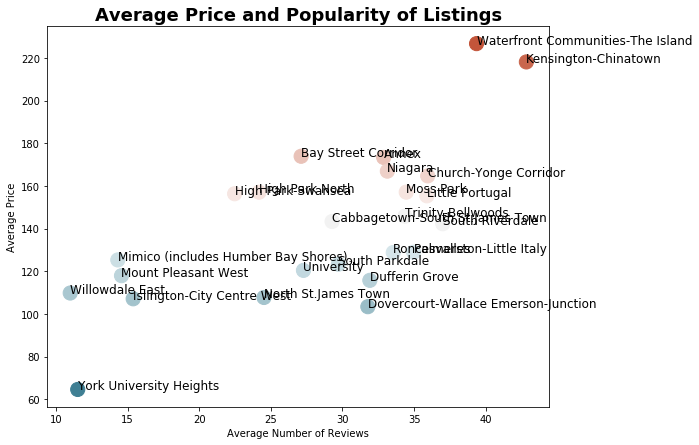

In [28]:
def plot_price_vs_popularity(df, top_k):
    x = df.groupby('neighbourhood_cleansed')[
        'number_of_reviews'].mean().sort_index()[:top_k]
    y = df.groupby('neighbourhood_cleansed')[
        'price'].mean().sort_index()[:top_k]
    n = (x.reset_index()).neighbourhood_cleansed.tolist()[:top_k]
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.scatter(x, y, c=y, cmap=sns.diverging_palette(
        220, 20, sep=20, as_cmap=True), s=200)

    for i, txt in enumerate(n):
        ax.annotate(txt, (x[i], y[i]), fontsize=12)

    plt.xlabel('Average Number of Reviews')
    plt.ylabel('Average Price')
    plt.title('Average Price and Popularity of Listings',
              fontsize=18, fontweight='bold')

plot_price_vs_popularity(top_nbrhd, 25)

# Modeling and Feature Engineering:

## Building a regression model to predict the price of the listings

In [29]:
features = ['cancellation_policy', 'is_location_exact', 'accommodates', 'reviews_per_month', 'property_type',
            'host_total_listings_count', 'extra_people', 'calculated_host_listings_count', 'guests_included',
            'review_scores_rating', 'host_response_time', 'number_of_reviews', 'host_is_superhost', 'room_type',
            'instant_bookable', 'amenities', 'host_identity_verified', 'host_has_profile_pic', 'security_deposit',
            'host_listings_count', 'requires_license','neighbourhood_cleansed',
            'minimum_nights', 'bathrooms', 'require_guest_phone_verification', 'cleaning_fee',
           'bed_type', 'price']


In [30]:
data = listings[features].copy()

In [31]:
### Preprocessing

data.cleaning_fee = data.cleaning_fee.str.replace('$', '').str.replace(',', '')
data.cleaning_fee = data.cleaning_fee.astype(float)

data.security_deposit = data.security_deposit.str.replace('$', '').str.replace(',', '')
data.security_deposit = data.security_deposit.astype(float)

data.extra_people = data.extra_people.str.replace('$', '').str.replace(',', '')
data.extra_people = data.extra_people.astype(float)


In [32]:
data.shape

(23397, 28)

In [33]:
target = data['price']
features = data.copy().drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Numerical columns filling null values

In [34]:
num_column_names = ['accommodates', 'reviews_per_month',
       'host_total_listings_count', 'extra_people',
       'calculated_host_listings_count', 'guests_included',
       'review_scores_rating', 'number_of_reviews', 'security_deposit',
       'host_listings_count', 'minimum_nights', 'bathrooms', 'cleaning_fee']

In [35]:
### Train numerical_columns

train_num_data = X_train.select_dtypes(exclude='object')
train_num_data.isnull().sum()

accommodates                         0
reviews_per_month                 3491
host_total_listings_count          229
extra_people                         0
calculated_host_listings_count       0
guests_included                      0
review_scores_rating              3713
number_of_reviews                    0
security_deposit                  4338
host_listings_count                229
minimum_nights                       0
bathrooms                            7
cleaning_fee                      2882
dtype: int64

In [36]:
train_num_data.head()

,accommodates,reviews_per_month,host_total_listings_count,extra_people,calculated_host_listings_count,guests_included,review_scores_rating,number_of_reviews,security_deposit,host_listings_count,minimum_nights,bathrooms,cleaning_fee
9008,2,0.92,1.0,0.0,1,1,98.0,23,349.0,1.0,5,1.0,29.0
15500,4,0.22,1.0,20.0,1,2,100.0,2,500.0,1.0,10,1.0,50.0
17829,4,2.81,9.0,20.0,8,2,91.0,16,NaN,9.0,3,2.0,NaN
12135,2,3.13,7.0,0.0,7,2,99.0,20,500.0,7.0,3,1.0,135.0
22036,2,NaN,0.0,0.0,1,1,NaN,0,NaN,0.0,1,0.0,NaN


In [37]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

## MICE (Multiple Imputation by Chained Equations)

To handle missing values in numerical columns

Better than Mean / Median Imputation as it keeps the variance as close to the original data
and does not create bias

In [38]:
imp_mean = IterativeImputer(random_state=0)
train_num_data = imp_mean.fit_transform(train_num_data)

In [39]:
train_num_data = pd.DataFrame(train_num_data, columns = num_column_names)
train_num_data.index = X_train.index

In [40]:
train_num_data.reviews_per_month = train_num_data.reviews_per_month.map(lambda x: 0 if x <0 else x)
train_num_data.security_deposit = train_num_data.security_deposit.map(lambda x: 0 if x <0 else x)

In [41]:
train_num_data.head()

,accommodates,reviews_per_month,host_total_listings_count,extra_people,calculated_host_listings_count,guests_included,review_scores_rating,number_of_reviews,security_deposit,host_listings_count,minimum_nights,bathrooms,cleaning_fee
9008,2.0,0.920000,1.0,0.0,1.0,1.0,98.000000,23.0,349.000000,1.0,5.0,1.0,29.000000
15500,4.0,0.220000,1.0,20.0,1.0,2.0,100.000000,2.0,500.000000,1.0,10.0,1.0,50.000000
17829,4.0,2.810000,9.0,20.0,8.0,2.0,91.000000,16.0,371.534315,9.0,3.0,2.0,75.225329
12135,2.0,3.130000,7.0,0.0,7.0,2.0,99.000000,20.0,500.000000,7.0,3.0,1.0,135.000000
22036,2.0,1.355457,0.0,0.0,1.0,1.0,93.721598,0.0,84.738460,0.0,1.0,0.0,25.844570


In [42]:
X_train[num_column_names] = train_num_data[num_column_names]
X_train.head()

,cancellation_policy,is_location_exact,accommodates,reviews_per_month,property_type,host_total_listings_count,extra_people,calculated_host_listings_count,guests_included,review_scores_rating,host_response_time,number_of_reviews,host_is_superhost,room_type,instant_bookable,amenities,host_identity_verified,host_has_profile_pic,security_deposit,host_listings_count,requires_license,neighbourhood_cleansed,minimum_nights,bathrooms,require_guest_phone_verification,cleaning_fee,bed_type
9008,moderate,t,2.0,0.920000,House,1.0,0.0,1.0,1.0,98.000000,within a few hours,23.0,f,Entire home/apt,t,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",f,t,349.000000,1.0,f,Hillcrest Village,5.0,1.0,f,29.000000,Real Bed
15500,moderate,t,4.0,0.220000,Bungalow,1.0,20.0,1.0,2.0,100.000000,within an hour,2.0,f,Entire home/apt,f,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",f,t,500.000000,1.0,f,Rockcliffe-Smythe,10.0,1.0,f,50.000000,Real Bed
17829,strict_14_with_grace_period,t,4.0,2.810000,House,9.0,20.0,8.0,2.0,91.000000,within an hour,16.0,f,Private room,t,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,""S...",t,t,371.534315,9.0,f,Lansing-Westgate,3.0,2.0,f,75.225329,Real Bed
12135,strict_14_with_grace_period,t,2.0,3.130000,Apartment,7.0,0.0,7.0,2.0,99.000000,within an hour,20.0,f,Entire home/apt,f,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",t,t,500.000000,7.0,f,Rosedale-Moore Park,3.0,1.0,f,135.000000,Real Bed
22036,flexible,t,2.0,1.355457,Tiny house,0.0,0.0,1.0,1.0,93.721598,within a day,0.0,f,Entire home/apt,t,"{TV,Wifi,""Smoking allowed"",""Suitable for event...",f,t,84.738460,0.0,f,Clanton Park,1.0,0.0,f,25.844570,Real Bed


## Fitting MICE on test data

In [43]:
#### Test numerical_columns
test_num_data = X_test.select_dtypes(exclude='object')
test_num_data = imp_mean.transform(test_num_data)
test_num_data = pd.DataFrame(test_num_data, columns = num_column_names)
test_num_data.index = X_test.index
test_num_data.head()

,accommodates,reviews_per_month,host_total_listings_count,extra_people,calculated_host_listings_count,guests_included,review_scores_rating,number_of_reviews,security_deposit,host_listings_count,minimum_nights,bathrooms,cleaning_fee
15736,3.0,0.12,1.0,0.0,1.0,1.0,100.0,1.0,250.0,1.0,2.0,1.0,45.0
3256,2.0,0.08,1.0,10.0,1.0,2.0,100.0,3.0,150.0,1.0,3.0,1.0,20.0
8081,4.0,1.64,1.0,100.0,1.0,4.0,96.0,45.0,300.0,1.0,2.0,2.0,75.0
18043,6.0,0.25,38.0,30.0,8.0,3.0,100.0,1.0,200.0,38.0,1.0,2.0,55.0
17993,5.0,1.25,2.0,10.0,1.0,3.0,89.0,7.0,0.0,2.0,3.0,1.0,46.0


In [44]:
X_test[num_column_names] = test_num_data[num_column_names]
X_test.head()

,cancellation_policy,is_location_exact,accommodates,reviews_per_month,property_type,host_total_listings_count,extra_people,calculated_host_listings_count,guests_included,review_scores_rating,host_response_time,number_of_reviews,host_is_superhost,room_type,instant_bookable,amenities,host_identity_verified,host_has_profile_pic,security_deposit,host_listings_count,requires_license,neighbourhood_cleansed,minimum_nights,bathrooms,require_guest_phone_verification,cleaning_fee,bed_type
15736,moderate,f,3.0,0.12,Condominium,1.0,0.0,1.0,1.0,100.0,NaN,1.0,f,Entire home/apt,f,"{TV,Wifi,""Air conditioning"",Kitchen,Gym,Elevat...",t,t,250.0,1.0,f,Niagara,2.0,1.0,f,45.0,Real Bed
3256,moderate,t,2.0,0.08,Apartment,1.0,10.0,1.0,2.0,100.0,NaN,3.0,f,Entire home/apt,f,"{Internet,Wifi,""Air conditioning"",Kitchen,Gym,...",f,t,150.0,1.0,f,Church-Yonge Corridor,3.0,1.0,f,20.0,Real Bed
8081,strict_14_with_grace_period,t,4.0,1.64,Condominium,1.0,100.0,1.0,4.0,96.0,within an hour,45.0,t,Entire home/apt,f,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",t,t,300.0,1.0,f,Regent Park,2.0,2.0,f,75.0,Real Bed
18043,strict_14_with_grace_period,t,6.0,0.25,Apartment,38.0,30.0,8.0,3.0,100.0,within a few hours,1.0,f,Entire home/apt,f,"{Wifi,""Air conditioning"",Kitchen,Heating,Washe...",f,t,200.0,38.0,f,Church-Yonge Corridor,1.0,2.0,f,55.0,Real Bed
17993,moderate,t,5.0,1.25,House,2.0,10.0,1.0,3.0,89.0,NaN,7.0,f,Entire home/apt,t,"{Wifi,""Air conditioning"",Kitchen,""Free parking...",f,t,0.0,2.0,f,Casa Loma,3.0,1.0,f,46.0,Real Bed


### Log and MinMax Scaling 

In [45]:
X_train[num_column_names] = X_train[num_column_names].apply(lambda x: np.log(x+1))
scaler = MinMaxScaler()
X_train[num_column_names] = scaler.fit_transform(X_train[num_column_names])

In [46]:
X_test[num_column_names] = X_test[num_column_names].apply(lambda x: np.log(x+1))
X_test[num_column_names] = scaler.transform(X_test[num_column_names])
X_test.head()

,cancellation_policy,is_location_exact,accommodates,reviews_per_month,property_type,host_total_listings_count,extra_people,calculated_host_listings_count,guests_included,review_scores_rating,host_response_time,number_of_reviews,host_is_superhost,room_type,instant_bookable,amenities,host_identity_verified,host_has_profile_pic,security_deposit,host_listings_count,requires_license,neighbourhood_cleansed,minimum_nights,bathrooms,require_guest_phone_verification,cleaning_fee,bed_type
15736,moderate,f,0.323891,0.039082,Condominium,0.119589,0.000000,0.000000,0.000000,0.949241,NaN,0.104087,f,Entire home/apt,f,"{TV,Wifi,""Air conditioning"",Kitchen,Gym,Elevat...",t,t,0.627723,0.119589,f,Niagara,0.064021,0.307889,f,0.539197,Real Bed
3256,moderate,t,0.189464,0.026540,Apartment,0.119589,0.400052,0.000000,0.189464,0.949241,NaN,0.208174,f,Entire home/apt,f,"{Internet,Wifi,""Air conditioning"",Kitchen,Gym,...",f,t,0.569992,0.119589,f,Church-Yonge Corridor,0.109445,0.307889,f,0.455792,Real Bed
8081,strict_14_with_grace_period,t,0.428160,0.334778,Condominium,0.119589,0.769962,0.000000,0.428160,0.924818,within an hour,0.574932,t,Entire home/apt,f,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",t,t,0.648360,0.119589,f,Regent Park,0.064021,0.487992,f,0.592604,Real Bed
18043,strict_14_with_grace_period,t,0.585385,0.076952,Apartment,0.632078,0.572908,0.365878,0.323891,0.949241,within a few hours,0.104087,f,Entire home/apt,f,"{Wifi,""Air conditioning"",Kitchen,Heating,Washe...",f,t,0.602486,0.632078,f,Church-Yonge Corridor,0.000000,0.487992,f,0.560121,Real Bed
17993,moderate,t,0.513354,0.279653,House,0.189545,0.400052,0.000000,0.323891,0.879549,NaN,0.312262,f,Entire home/apt,t,"{Wifi,""Air conditioning"",Kitchen,""Free parking...",f,t,0.000000,0.189545,f,Casa Loma,0.109445,0.307889,f,0.541485,Real Bed


### Categorical columns filling null values

In [47]:
train_cat_data = X_train.select_dtypes(include='object')
train_cat_data.isnull().sum()

cancellation_policy                    0
is_location_exact                      0
property_type                          0
host_response_time                  5317
host_is_superhost                    229
room_type                              0
instant_bookable                       0
amenities                              0
host_identity_verified               229
host_has_profile_pic                 229
requires_license                       0
neighbourhood_cleansed                 0
require_guest_phone_verification       0
bed_type                               0
dtype: int64

In [48]:
imp_mode = SimpleImputer(strategy='most_frequent')
cat_columns = train_cat_data.columns
train_cat_data = imp_mode.fit_transform(train_cat_data)

In [49]:
train_cat_data = pd.DataFrame(train_cat_data, columns = cat_columns)
train_cat_data.index = X_train.index

In [50]:
train_cat_data.head()

,cancellation_policy,is_location_exact,property_type,host_response_time,host_is_superhost,room_type,instant_bookable,amenities,host_identity_verified,host_has_profile_pic,requires_license,neighbourhood_cleansed,require_guest_phone_verification,bed_type
9008,moderate,t,House,within a few hours,f,Entire home/apt,t,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",f,t,f,Hillcrest Village,f,Real Bed
15500,moderate,t,Bungalow,within an hour,f,Entire home/apt,f,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",f,t,f,Rockcliffe-Smythe,f,Real Bed
17829,strict_14_with_grace_period,t,House,within an hour,f,Private room,t,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,""S...",t,t,f,Lansing-Westgate,f,Real Bed
12135,strict_14_with_grace_period,t,Apartment,within an hour,f,Entire home/apt,f,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",t,t,f,Rosedale-Moore Park,f,Real Bed
22036,flexible,t,Tiny house,within a day,f,Entire home/apt,t,"{TV,Wifi,""Smoking allowed"",""Suitable for event...",f,t,f,Clanton Park,f,Real Bed


In [51]:
X_train[cat_columns] = train_cat_data[cat_columns]
X_train.head()

,cancellation_policy,is_location_exact,accommodates,reviews_per_month,property_type,host_total_listings_count,extra_people,calculated_host_listings_count,guests_included,review_scores_rating,host_response_time,number_of_reviews,host_is_superhost,room_type,instant_bookable,amenities,host_identity_verified,host_has_profile_pic,security_deposit,host_listings_count,requires_license,neighbourhood_cleansed,minimum_nights,bathrooms,require_guest_phone_verification,cleaning_fee,bed_type
9008,moderate,t,0.189464,0.224957,House,0.119589,0.000000,0.000000,0.000000,0.937153,within a few hours,0.477236,f,Entire home/apt,t,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",f,t,0.665495,0.119589,f,Hillcrest Village,0.173467,0.307889,f,0.493731,Real Bed
15500,moderate,t,0.428160,0.068575,Bungalow,0.119589,0.507932,0.000000,0.189464,0.949241,within an hour,0.164974,f,Entire home/apt,f,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",f,t,0.706242,0.119589,f,Rockcliffe-Smythe,0.269173,0.307889,f,0.550173,Real Bed
17829,strict_14_with_grace_period,t,0.428160,0.461288,House,0.397267,0.507932,0.365878,0.189464,0.892833,within an hour,0.425453,f,Private room,t,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,""S...",t,t,0.672583,0.397267,f,Lansing-Westgate,0.109445,0.487992,f,0.592919,Real Bed
12135,strict_14_with_grace_period,t,0.189464,0.489100,Apartment,0.358768,0.000000,0.337226,0.189464,0.943227,within an hour,0.457184,f,Entire home/apt,f,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",t,t,0.706242,0.358768,f,Rosedale-Moore Park,0.109445,0.307889,f,0.654501,Real Bed
22036,flexible,t,0.189464,0.295449,Tiny house,0.000000,0.000000,0.000000,0.000000,0.910453,within a day,0.000000,f,Entire home/apt,t,"{TV,Wifi,""Smoking allowed"",""Suitable for event...",f,t,0.505693,0.000000,f,Clanton Park,0.000000,0.000000,f,0.481910,Real Bed


In [52]:
test_cat_data = X_test.select_dtypes(include='object')
test_cat_data = imp_mode.transform(test_cat_data)
test_cat_data = pd.DataFrame(test_cat_data, columns = cat_columns)
test_cat_data.index = X_test.index
X_test[cat_columns] = test_cat_data[cat_columns]
X_test.head()

,cancellation_policy,is_location_exact,accommodates,reviews_per_month,property_type,host_total_listings_count,extra_people,calculated_host_listings_count,guests_included,review_scores_rating,host_response_time,number_of_reviews,host_is_superhost,room_type,instant_bookable,amenities,host_identity_verified,host_has_profile_pic,security_deposit,host_listings_count,requires_license,neighbourhood_cleansed,minimum_nights,bathrooms,require_guest_phone_verification,cleaning_fee,bed_type
15736,moderate,f,0.323891,0.039082,Condominium,0.119589,0.000000,0.000000,0.000000,0.949241,within an hour,0.104087,f,Entire home/apt,f,"{TV,Wifi,""Air conditioning"",Kitchen,Gym,Elevat...",t,t,0.627723,0.119589,f,Niagara,0.064021,0.307889,f,0.539197,Real Bed
3256,moderate,t,0.189464,0.026540,Apartment,0.119589,0.400052,0.000000,0.189464,0.949241,within an hour,0.208174,f,Entire home/apt,f,"{Internet,Wifi,""Air conditioning"",Kitchen,Gym,...",f,t,0.569992,0.119589,f,Church-Yonge Corridor,0.109445,0.307889,f,0.455792,Real Bed
8081,strict_14_with_grace_period,t,0.428160,0.334778,Condominium,0.119589,0.769962,0.000000,0.428160,0.924818,within an hour,0.574932,t,Entire home/apt,f,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",t,t,0.648360,0.119589,f,Regent Park,0.064021,0.487992,f,0.592604,Real Bed
18043,strict_14_with_grace_period,t,0.585385,0.076952,Apartment,0.632078,0.572908,0.365878,0.323891,0.949241,within a few hours,0.104087,f,Entire home/apt,f,"{Wifi,""Air conditioning"",Kitchen,Heating,Washe...",f,t,0.602486,0.632078,f,Church-Yonge Corridor,0.000000,0.487992,f,0.560121,Real Bed
17993,moderate,t,0.513354,0.279653,House,0.189545,0.400052,0.000000,0.323891,0.879549,within an hour,0.312262,f,Entire home/apt,t,"{Wifi,""Air conditioning"",Kitchen,""Free parking...",f,t,0.000000,0.189545,f,Casa Loma,0.109445,0.307889,f,0.541485,Real Bed


In [53]:
X_train.shape

(18717, 27)

In [54]:
X_test.shape

(4680, 27)

In [55]:
dummies = ['property_type', 'room_type', 'cancellation_policy',
           'host_response_time', 'neighbourhood_cleansed', 'bed_type']
columns =  ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'requires_license', 'instant_bookable', 'require_guest_phone_verification']

In [56]:
all_data = pd.concat([X_train,X_test])

In [57]:
for column in dummies:
    X_train[column] = X_train[column].astype('category', categories = all_data[column].unique())
    X_test[column] = X_test[column].astype('category', categories = all_data[column].unique())

In [58]:
for cat_feature in dummies:
    X_train = pd.concat([X_train, pd.get_dummies(X_train[cat_feature], prefix=cat_feature)], axis=1)
    
X_train = X_train.drop(dummies,axis=1)

for c in columns:
    X_train[c] = X_train[c].replace('f',0,regex=True)
    X_train[c] = X_train[c].replace('t',1,regex=True)
    

In [59]:
for cat_feature in dummies:
    X_test = pd.concat([X_test, pd.get_dummies(X_test[cat_feature], prefix=cat_feature)], axis=1)
    
X_test = X_test.drop(dummies,axis=1)

for c in columns:
    X_test[c] = X_test[c].replace('f',0,regex=True)
    X_test[c] = X_test[c].replace('t',1,regex=True)
    


In [60]:
print(X_train.shape,X_test.shape)

(18717, 209) (4680, 209)


In [61]:
y_train = y_train.map(lambda x: np.log(x+1))
y_test = y_test.map(lambda x: np.log(x+1))

In [62]:
print(y_train.shape,y_test.shape)

(18717,) (4680,)


In [63]:
X_train['number_of_amenities'] = X_train['amenities'].apply(lambda x: len(x.replace('{', '').replace('}', '').split(',')))
X_test['number_of_amenities'] = X_test['amenities'].apply(lambda x: len(x.replace('{', '').replace('}', '').split(',')))


In [64]:
X_train.amenities = X_train.amenities.str.replace("[{}]", "").str.replace('"', "")

count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(','))

train_amenities = count_vectorizer.fit_transform(X_train['amenities'])


In [65]:
feature_names = []
for i, f in enumerate(count_vectorizer.get_feature_names()):
    feature_names.append('f'+str(i))

In [66]:
df_amenities = pd.DataFrame(train_amenities.toarray(), columns=feature_names, index = X_train.index)
df_amenities = df_amenities.drop('f0',1)

In [67]:
X_train.shape

(18717, 210)

In [68]:
X_train.drop('amenities',axis=1, inplace=True)

In [69]:
X_train = pd.concat([X_train, df_amenities], axis=1,join = 'inner')

In [70]:
X_train.shape

(18717, 406)

In [71]:
X_test.amenities = X_test.amenities.str.replace("[{}]", "").str.replace('"', "")
test_amenities = count_vectorizer.transform(X_test['amenities'])
df_amenities = pd.DataFrame(test_amenities.toarray(), columns=feature_names, index = X_test.index)
df_amenities = df_amenities.drop('f0',1)
X_test.drop('amenities',axis=1, inplace=True)
X_test = pd.concat([X_test, df_amenities], axis=1,join = 'inner')

In [72]:
X_test.shape

(4680, 406)

## Modeling Step: 

### Used Light GBM as the model because:

Faster training speed and convergence

Lower memory usage

Can handle very large size data-sets

Better accuracy than any other boosting algorithm

R^2 test: 0.693
R^2 train: 0.924


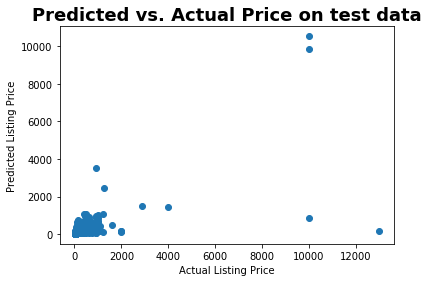

In [73]:
model = LGBMRegressor(n_estimators=1000)
    
model.fit(X_train, y_train)  
y_test_pred = model.predict(X_test) 
print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

y_pred = model.predict(X_train) 
print('R^2 train: %.3f' % (r2_score(y_train, y_pred)))

pred = np.round(np.exp(y_test_pred) + 1, 1)
actual = np.round(np.exp(y_test) + 1, 1)

plt.scatter(actual, pred)
plt.title('Predicted vs. Actual Price on test data', fontsize=18, fontweight='bold')
plt.xlabel('Actual Listing Price')
plt.ylabel('Predicted Listing Price')
plt.show()


## Feature Importances are also reported from the model

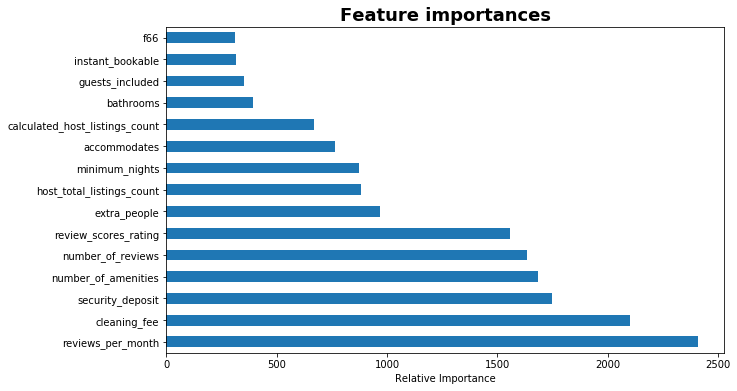

In [74]:
feat_imp = pd.Series(model.feature_importances_, index=X_train.columns)
feat_imp.nlargest(15).plot(kind='barh', figsize=(10, 6))
plt.xlabel('Relative Importance')
plt.title("Feature importances", fontsize=18, fontweight='bold')
plt.show()